# Modelling and analysing RNA circuit dynamics

Computational tools in synthetic biology are becoming increasingly sophisticated. The first comprehensive cell simulation was published recently for E. coli [reference] and it seems that every week there is a new neural network-based predictor for core genetic parts such as promoters, toehold sequences and and ribosome binding sites [references].

In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'gpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.type_handling import flatten_listlike, append_nest_dicts
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller

CONFIG = prepare_config(CONFIG)
root_dir = '..'

We will import some data summarising a previous simulation of 2000 randomly generated RNA circuits and their mutated iterations. For each starting or "reference" circuit, a mutated circuit was generated with $m$ mutations on each RNA species $s$ in the circuit. Because each of these mutations is administered randomly, some $n$ number of versions is repeated for each mutated iteration with $m$ mutations on species $s$. The exact settings for this dataset were the following:

$$
m = [1, 2, 3, 5, 10, 15]
$$
$$
s = [RNA_0, RNA_1, RNA_2]
$$
$$
n = 10
$$

This means that for each circuit, 6 mutated iterations $m$ were generated for each of the 3 RNA species $s$ with $n = 10$ samples for each, giving 180 mutated circuits for each reference circuit and thus a total of $2000 * 181 = 362000$ circuits.

# Case study: studying specific circuits' dynamics


## Choosing circuits with similar and different dynamics

In order to find good candidates for a case study, we want to look at circuits where some have similar dynamics metrics between them, some have vastly different dynamics but similar values, and some have highly varying metrics on all accounts. We especially want to look at circuits with possible contradictions, such as those where the minimum and maximum values reached by the signalling RNA ($RNA_0$) are similar, yet some of the signal analytics suggest a big change between these values.

### Load Data

In [3]:
fn = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
data = pd.read_csv(fn)
# data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
# dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)


In [4]:
config = load_json_as_dict(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'

### Get means and STDs

In [5]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c)]
# agg1 = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: 'std' for c in analytics})
agg1_stds = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.std(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean = data.groupby(['circuit_name', 'mutation_num', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(x) if sum(x) != 0.0 else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})

### Find circuits with optimal distance in their function

Here we are looking at the circuits with minimal distance between their sensitivities and precisions, while having a maximum distance between the variation of the change in their precision between reference and mutated circuits, so the standard deviation of the precision ratio between from a mutant to it reference circuit.

In [6]:
filts = (agg1_mean['sample_name'] == 'RNA_2') & (agg1_mean['precision_wrt_species-6'] != np.inf) & (
    agg1_mean['precision_wrt_species-6'] > 2) & ((agg1_mean['num_interacting'] > 1) | (agg1_mean['num_self_interacting'] > 1))

p = agg1_mean[filts]['precision_wrt_species-6'].to_numpy()
s = agg1_mean[filts]['sensitivity_wrt_species-6'].to_numpy()
st = agg1_stds[filts]['precision_wrt_species-6_ratio_from_mutation_to_base'].to_numpy()

std_diffs = np.log(st[:, None] / st[None, :])
prec_diffs = np.log(p[:, None] / p[None, :])
sens_diffs = np.log(s[:, None] / s[None, :])

std_diffs = np.where(np.isnan(std_diffs) | (np.abs(std_diffs) == np.inf), 0, std_diffs)
weighting_prec = 1
weighting_sens = 1
weighting_stds = 0.1
joint_diffs = weighting_prec * np.abs(prec_diffs) + weighting_sens * np.abs(sens_diffs)
joint_diffs_rev = np.where(joint_diffs != 0, joint_diffs.max() - np.abs(joint_diffs), 0)
joint = joint_diffs_rev + weighting_stds * np.abs(std_diffs)

circ1, circ2 = np.where(joint == np.abs(joint).max()) 
circ1, circ2 = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1, circ2)]))).T

circ1_m_df = agg1_mean[filts].iloc[circ1]
circ2_m_df = agg1_mean[filts].iloc[circ2]
circ1_s_df = agg1_stds[filts].iloc[circ1]
circ2_s_df = agg1_stds[filts].iloc[circ2]


/tmp/ipykernel_43516/2109556873.py:8: RuntimeWarning: divide by zero encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_43516/2109556873.py:8: RuntimeWarning: invalid value encountered in divide
  std_diffs = np.log(st[:, None] / st[None, :])
/tmp/ipykernel_43516/2109556873.py:8: RuntimeWarning: divide by zero encountered in log
  std_diffs = np.log(st[:, None] / st[None, :])


### Check that the expected circuits were selected

Visualising the precision and sensitivity of the circuits, along with the variation in precision ratio.

Text(0.5, 0.98, 'Precision mean for $RNA_2$')

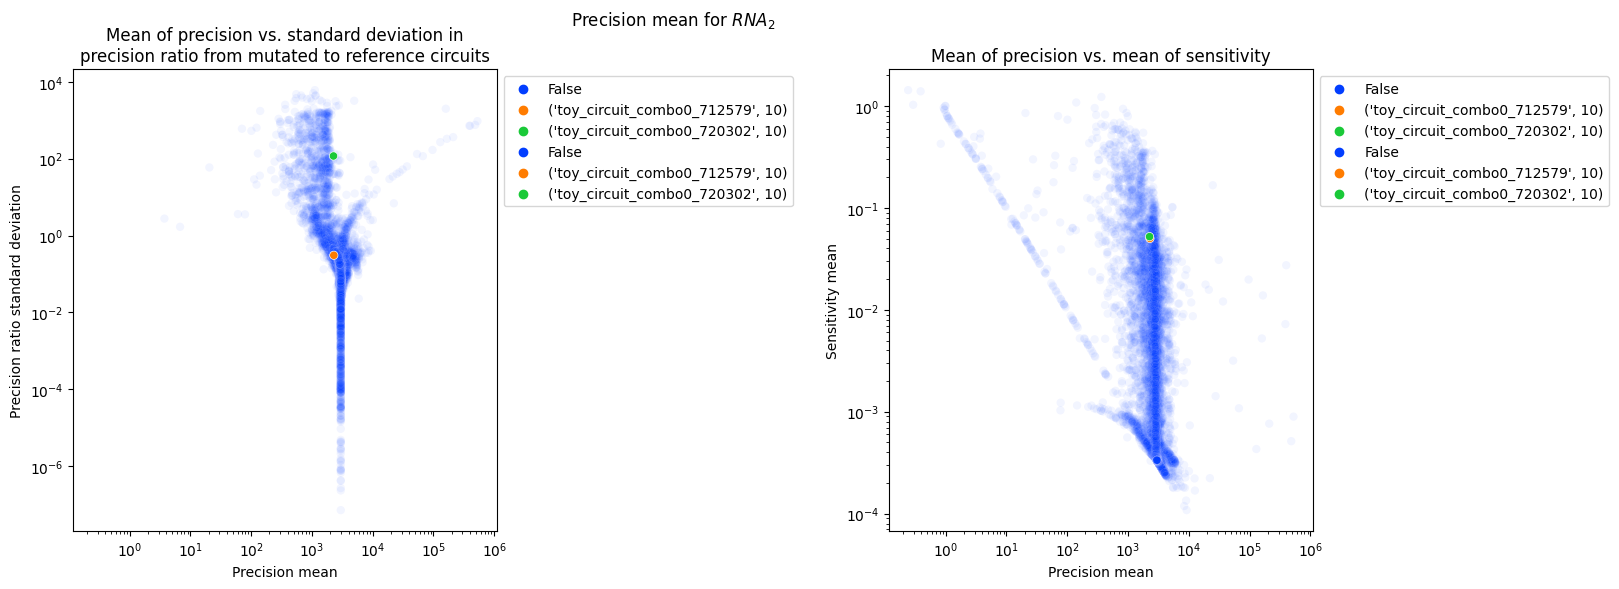

In [7]:
filt = (agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sample_name'] == 'RNA_2')
c1n, c1m = circ1_m_df['circuit_name'].values[0], circ1_m_df['mutation_num'].values[0]
c2n, c2m = circ2_m_df['circuit_name'].values[0], circ2_m_df['mutation_num'].values[0]
hue_d = {c1n: c1m, c2n: c2m}
# hue = jax.tree_util.tree_map(lambda c, m: (c,m) if (c in [c1n, c2n]) and (m == hue_d[c]) else False, list(agg1_mean[filt]['circuit_name'].values), list(agg1_mean[filt]['mutation_num'].values))
hue = list(map(lambda i, c, m: (c, m) if (i == circ1_m_df.index[0]) or (i == circ2_m_df.index[0]) else False, 
               list(agg1_mean[filt].index), list(agg1_mean[filt]['circuit_name'].values), list(agg1_mean[filt]['mutation_num'].values)))
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(wspace=0.925)

ax = plt.subplot(1,2,1)
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_stds[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_stds[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision ratio standard deviation')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

filt = (agg1_mean['precision_wrt_species-6'] < np.inf) & (agg1_mean['sensitivity_wrt_species-6'] < np.inf) & (agg1_mean['sample_name'] == 'RNA_2')
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

ax = plt.subplot(1,2,2)
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_mean[filt]['sensitivity_wrt_species-6'], 
                alpha=0.05,
                hue=hue,
                palette="bright")
sns.scatterplot(x=agg1_mean[filt]['precision_wrt_species-6'], y=agg1_mean[filt]['sensitivity_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette="bright")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precision mean')
plt.ylabel('Sensitivity mean')
plt.title('Mean of precision vs. mean of sensitivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

plt.suptitle('Precision mean for $RNA_2$')



As you can see from graphs above, the 2 circuits chosen are very close in terms of their average precision and sensitivity (right graph), but over 2 orders of magnitude apart in the variation of their precision ratio change from mutated to reference circuit (left graph).

## Simulate the chosen circuits

### Load circuits

We will load the two circuits selected and all the circuits with same reference circuit. 

In [8]:


def load_circuit(circ_row, config, og_dir: str):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        if np.power(length, 2) == len(flattened_vector):
            length = int(np.sqrt(len(flattened_vector)))
            return flattened_vector.reshape((length, length))
        
        matrix = [[0] * length for _ in range(length)]
        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1
        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')].values.squeeze()),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')].values.squeeze()),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')].values.squeeze()),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')].values.squeeze())}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

def batch_load(circ_rows: pd.DataFrame, ref_c: pd.DataFrame, og_dir: str, config: dict):
    circuits = []
    circuits.append(load_circuit(circ_row=ref_c.iloc[0], config=config, og_dir=og_dir))
    for i, circ_row in circ_rows.iterrows():
        circuits.append(load_circuit(circ_row=circ_row, config=config, og_dir=og_dir))
    return circuits

circ_rows1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_2')]
ref_c1 = data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_2')]
circ_rows2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ2_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == 'RNA_2')]
ref_c2 = data[(data['circuit_name'] == circ2_m_df['circuit_name'].values[0]) & (data['mutation_name'] == 'ref_circuit') & (data['sample_name'] == 'RNA_2')]
circuits1 = batch_load(circ_rows1, ref_c1, og_dir, config)
circuits2 = batch_load(circ_rows2, ref_c2, og_dir, config)
circuits = circuits1 + circuits2



xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


We also load and set the simulation parameters, such as the total simulation time, time step $dt$, threshold for considering a time step as having reached steady state, etc. Certain parameters like the signal strength are loaded from the original config used to generate the data in the first place.

In [9]:

config = load_json_as_dict(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
signal_target = config['signal']['function_kwargs']['target']
signal_target

2

In [10]:

forward_rates = circuits1[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])

t0 = 0 
t1 = 500
dt = 0.001
tmax = 5000
threshold_steady_states = 0.01
save_steps = 1000  # int(np.min([200, t1-t0]))

signal_onehot = np.zeros_like(circuits1[0].signal.reactions_onehot) if circuits1[0].use_prod_and_deg else np.zeros_like(circuits1[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits1[0].qreactions.reactions.inputs,
                            outputs=circuits1[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, save_steps))
                            )))

Below the actual simulation functions are run. Tirst the steady states of the unperturbed system are simualted, then the signal is added. Each of these two steps take a few minutes.

In [11]:


signal = circuits[0].signal

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)

signal_species = 'RNA_0'
signal_species_idx = np.where(circuits1[0].signal.onehot)[0][0]

b_steady_states = b_copynumbers[:, :, -1]
# b_steady_states[:, signal_species_idx] += b_copynumbers[:, signal_species_idx, 0] * signal_target

b_steady_states = (b_copynumbers[:, :, -1] * ((signal.onehot == 0) * 1)) + \
    (b_copynumbers[:, :, 0] *
     signal_target) * signal.onehot
                            
# b_steady_states[i] = c.result_collector.get_result(
#                             'steady_states').analytics['steady_states'].flatten() * ((signal.onehot == 0) * 1) + \
#                             (c.result_collector.get_result(
#                                 'steady_states').analytics['initial_steady_states'].flatten() *
#                              signal.func.keywords['target']) * signal.onehot


Done:  0:08:12.250735


In [12]:
b_copynumbers.shape

(40, 9, 1000)

In [13]:

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

Done:  0:08:05.848478


### Visualise traces

The traces of the two circuit families are plotted below. Each plot is labelled with whether it is the first or second comparative circuit, along with its circuit name and sub mutation name.

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

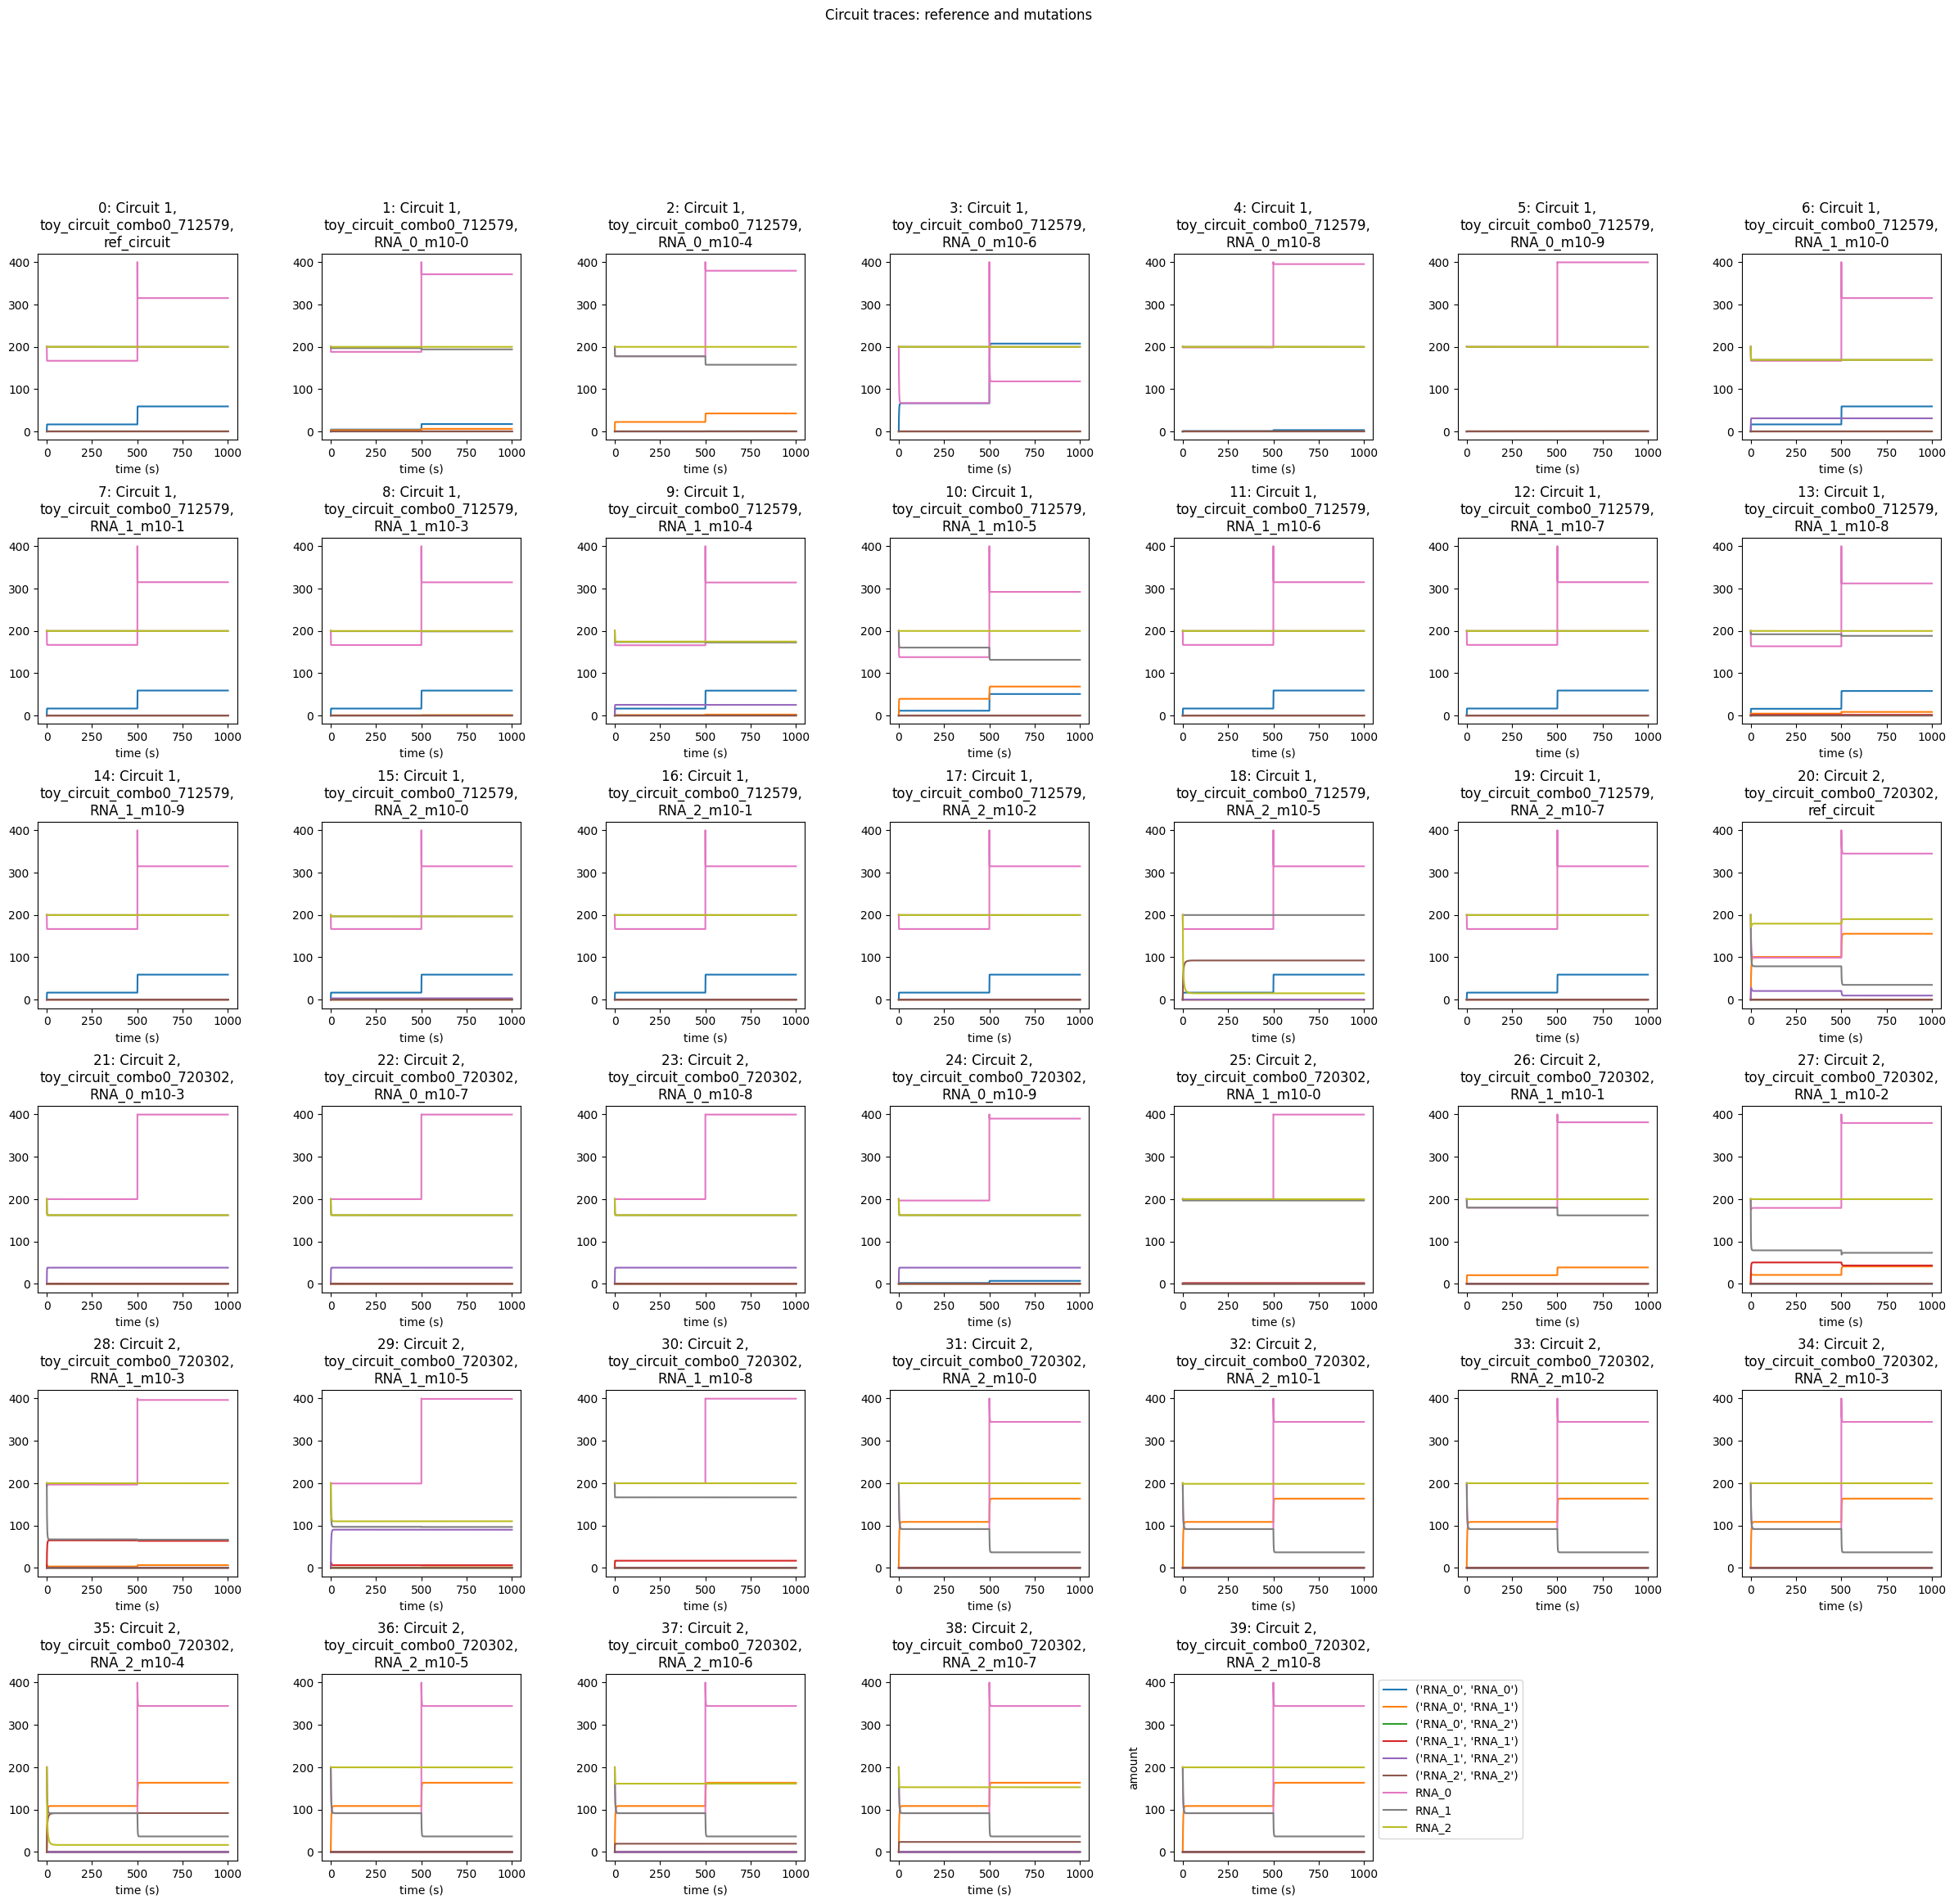

In [14]:
num_circuits = len(circuits)
nm=0
tdisplay = (0, len(tss) + len(tyy))
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525, wspace=0.425)
for i, circ in enumerate(circuits):
    ax = plt.subplot(7,7,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]])[tdisplay[0]:tdisplay[1]], np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T])[tdisplay[0]:tdisplay[1]])
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{i}: {circ_type},\n{circuits[i].name},\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


To make sure that the signal response is in fact smooth, we zoom in at the point of signal addition.

Text(0.5, 0.98, 'Circuit traces: reference and mutations')

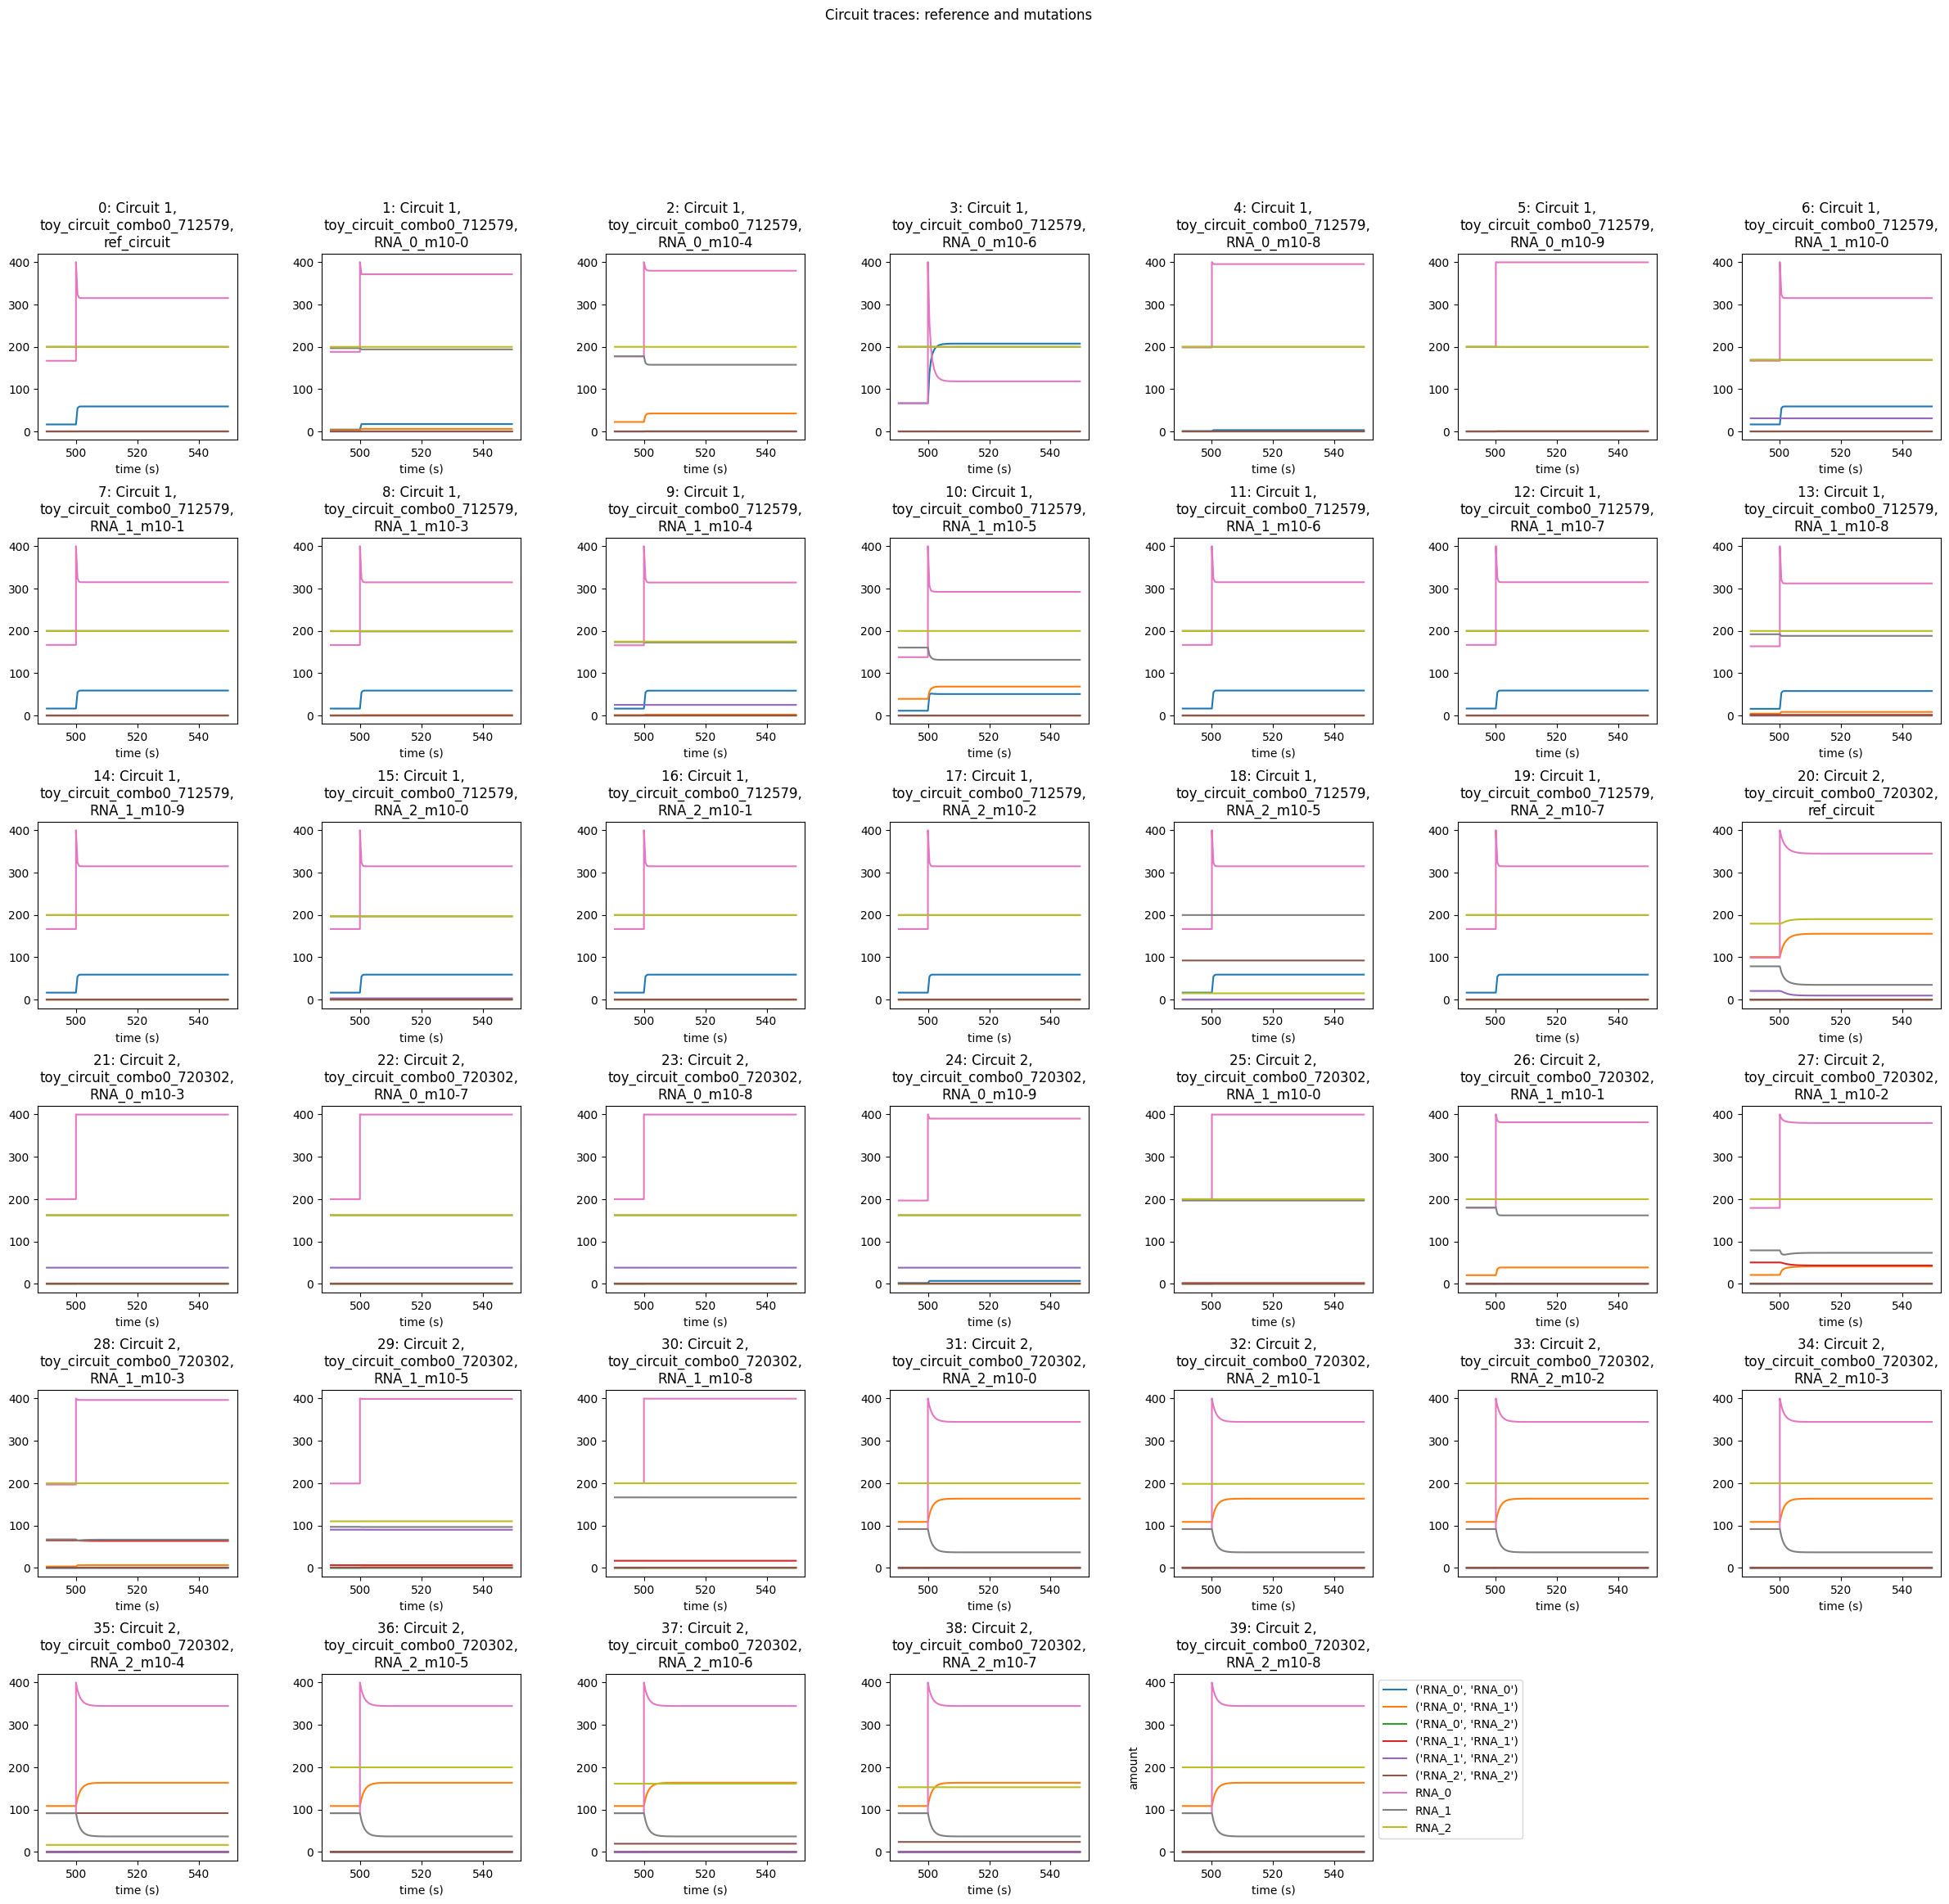

In [15]:
num_circuits = len(circuits)
nm=0
tdisplay = (len(tss) - 20, len(tss) + 100)
fig = plt.figure(figsize=(30, 30))
fig.subplots_adjust(hspace=0.525, wspace=0.425)
for i, circ in enumerate(circuits):
    ax = plt.subplot(7,7,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]])[tdisplay[0]:tdisplay[1]], np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T])[tdisplay[0]:tdisplay[1]])
    circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
    plt.title(f'{i}: {circ_type},\n{circuits[i].name},\n{circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


In [16]:

# print('Circuit 1')
# data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_num'] == circ1_m_df['mutation_num'].values[0]) & (data['num_interacting'] | data['num_self_interacting']) & (data['sample_name'] == circ1_m_df['sample_name'].values[0]) ][
#     ['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions', 'num_interacting', 'num_self_interacting', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
# ]

### Validate the analytics

As a sanity check, let's make sure that the analytics that we have in our `data` table are what we would expect from our simulations. This is primarily to check that all the simulated data is merged back into a summary table in the correct way.

In [17]:
t = np.concatenate([tss, tyy + tss[-1]])
all_copynumbers = np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T])
ref_idxs = [0, 26]
ref_idxs2 = ref_idxs[1:] + [len(circuits)]

b_analytics_l = []
for ref_idx, ref_idx2 in zip(ref_idxs, ref_idxs2):
    ref_circuit = circuits[ref_idx]
    signal = ref_circuit.signal
    ref_circuit_data = b_new_copynumbers[ref_idx]
    analytics_func = jax.vmap(partial(
        generate_analytics, time=tyy, labels=[
            s.name for s in ref_circuit.model.species],
        signal_onehot=signal.onehot, signal_time=signal.func.keywords[
            'impulse_center'],
        ref_circuit_data=ref_circuit_data))
    b_analytics = analytics_func(
        data=b_new_copynumbers[ref_idx:ref_idx2])
    b_analytics_l = append_nest_dicts(
        b_analytics_l, ref_idx2 - ref_idx, b_analytics)

The analytics calculated in this notebook do correspond to the correct circuit and to the previously simulated analytics in the original dataset. We will check the analytics calculated in this notebook with the ones listed in the data table using a specific circuit. 

In [18]:
chosen_circuit_idx = 1

df_calculated = pd.DataFrame({k: v.squeeze() for k, v in b_analytics_l[chosen_circuit_idx].items() if 'first_derivative' not in k}, index=np.arange(len(b_analytics_l[chosen_circuit_idx]['RMSE'].squeeze())))
df_calculated

,RMSE,RMSE_diff_to_base_circuit,RMSE_ratio_from_mutation_to_base,fold_change,fold_change_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states,initial_steady_states_diff_to_base_circuit,initial_steady_states_ratio_from_mutation_to_base,max_amount,...,precision_wrt_species-6_ratio_from_mutation_to_base,response_time_wrt_species-6,response_time_wrt_species-6_diff_to_base_circuit,response_time_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,steady_states,steady_states_diff_to_base_circuit,steady_states_ratio_from_mutation_to_base
0,41.649971,41.649971,inf,3.900773,0.334832,1.093897,4.454036,-12.104826,0.268982,17.374186,...,0.334017,inf,inf,inf,40.243290,2.817868e+01,3.335649,17.374186,-41.673737,0.294239
1,5.924125,5.924125,inf,1.945646,0.057766,1.030598,3.100148,3.044275,55.484917,6.032713,...,0.354537,inf,inf,inf,13.123357,8.700441e+00,2.967128,6.031792,5.926309,57.182652
2,0.018817,0.018817,inf,1.974439,0.086558,1.045849,0.062960,0.007087,1.126833,0.124318,...,0.344061,inf,inf,inf,13.520100,9.097183e+00,3.056829,0.124311,0.018828,1.178498
3,0.003902,0.003902,inf,0.970459,-0.029033,0.970952,0.064899,-0.002020,0.969812,0.064899,...,0.006498,-0.499499,0.000000,1.000000,0.409911,4.074357e-01,165.583008,0.062982,-0.003903,0.941641
4,0.001985,0.001985,inf,0.984820,-0.014673,0.985320,0.065900,-0.001019,0.984766,0.065900,...,0.012626,-0.499499,0.000000,1.000000,0.210637,2.081605e-01,85.050568,0.064900,-0.001986,0.970310
5,0.000010,0.000010,inf,0.999393,-0.000099,0.999901,0.066916,-0.000003,0.999952,0.066916,...,0.316282,-0.499499,0.000000,1.000000,0.008422,5.946040e-03,3.401894,0.066876,-0.000010,0.999853
6,56.203728,56.203728,inf,0.927919,0.140602,1.178584,400.000000,0.000000,1.000000,400.000000,...,1.114163,-0.499499,-0.500501,-499.000305,1.000000,5.960464e-08,1.000000,371.167633,56.240967,1.178584
7,5.912296,5.912296,inf,0.985119,-0.014627,0.985369,196.703781,-3.037964,0.984791,196.703781,...,0.006445,-0.499499,0.000000,1.000000,0.206492,2.052546e-01,166.876892,193.776535,-5.914474,0.970382
8,0.014686,0.014686,inf,0.999697,-0.000049,0.999951,199.736923,-0.004822,0.999976,199.736923,...,0.316088,inf,inf,-inf,0.004210,2.972304e-03,3.402074,199.676315,-0.014694,0.999926


In [19]:
c = circuits[chosen_circuit_idx]
print(f'Precision and sensitivity calculated for chosen circuit {chosen_circuit_idx}:')
print(c.name, c.subname, '\n')
df_calculated[['precision_wrt_species-6', 'sensitivity_wrt_species-6']]

Precision and sensitivity calculated for chosen circuit 1:
toy_circuit_combo0_712579 RNA_0_m10-0 



,precision_wrt_species-6,sensitivity_wrt_species-6
0,0.024833,40.243290
1,0.076174,13.123357
2,0.073923,13.520100
3,2.438397,0.409911
4,4.745234,0.210637
5,118.686066,0.008422
6,0.999344,1.000000
7,4.840483,0.206492
8,237.391006,0.004210


We now need to load the original file into which the analytics for this specific circuit were written and make sure that they match up with what we have calculated here.

In [20]:

os.listdir(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', c.name, 'mutations', c.subname))

['binding_rates_dissociation',
 'binding_sites',
 'report_signal.json',
 'report_steady_states.json',
 'energies',
 'output_summary.csv',
 'eqconstants']

Loading the original report can be done by looking into the same experiment directory that the `data` table was generated in. Because of the way the simulation output is stored, there are different top directories corresponding to a `purpose` into which things like circuit FASTAs, analytics, mutations, and circuit summary tables are written into. This is to allow different parts of the simulation to be split up dynamically and ensure that failure in one part of the simulation does not prohibit partial data salvation.

In [21]:
fn_report = os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', c.name, 'mutations', c.subname, 'report_signal.json')
fn_report_ss = os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', c.name, 'mutations', c.subname, 'report_steady_states.json')

df_report = pd.DataFrame.from_dict(load_json_as_dict(fn_report))
df_report_ss = pd.DataFrame.from_dict(load_json_as_dict(fn_report_ss))
df_report[['initial_steady_states', 'steady_states', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base']]

,initial_steady_states,steady_states,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base
0,0.0,17.37419,0.85584164,0.28119642,1.4893391,inf,nan,nan
1,0.0,6.0317864,0.85584164,0.28119642,1.4893391,inf,nan,nan
2,0.0,0.1243112,0.85584164,0.28119642,1.4893391,inf,nan,nan
3,0.06489932,0.06298141,28.96051,-1081.7053,0.026074907,0.03452978,0.033636704,38.663895
4,0.06589991,0.064899065,56.352325,-1054.3136,0.050737422,0.017745497,0.016852422,19.870096
5,0.06691594,0.06687511,1402.6597,291.99377,1.2628998,0.00071293133,-0.00018014427,0.7982878
6,200.0,371.16833,1.0,-1.1920929e-07,0.9999999,1.0,0.0,1.0
7,196.7039,193.77562,57.490128,-2162.763,0.0258935,0.017394291,0.016947536,38.93477
8,199.73662,199.67569,2805.6387,585.3855,1.263657,0.0003564251,-9.032962e-05,0.79780936


In [22]:

print('Circuit 1')
data[(data['circuit_name'] == circ1_m_df['circuit_name'].values[0]) & (data['mutation_name'] == c.subname)][
    ['circuit_name', 'mutation_name', 'mutation_num', 'num_interacting', 'num_self_interacting', 'initial_steady_states', 'steady_states', 'precision_wrt_species-6', 'precision_wrt_species-6_diff_to_base_circuit', 'precision_wrt_species-6_ratio_from_mutation_to_base', 'sensitivity_wrt_species-6', 'sensitivity_wrt_species-6_diff_to_base_circuit', 'sensitivity_wrt_species-6_ratio_from_mutation_to_base', 'sample_name']
]

Circuit 1


,circuit_name,mutation_name,mutation_num,num_interacting,num_self_interacting,initial_steady_states,steady_states,precision_wrt_species-6,precision_wrt_species-6_diff_to_base_circuit,precision_wrt_species-6_ratio_from_mutation_to_base,sensitivity_wrt_species-6,sensitivity_wrt_species-6_diff_to_base_circuit,sensitivity_wrt_species-6_ratio_from_mutation_to_base,sample_name
735255,toy_circuit_combo0_712579,RNA_0_m10-0,10,1,1,200.00000,371.16833,1.000000,-1.192093e-07,1.000000,1.000000,0.000000,1.000000,RNA_0
735256,toy_circuit_combo0_712579,RNA_0_m10-0,10,1,1,196.70390,193.77562,57.490128,-2.162763e+03,0.025893,0.017394,0.016948,38.934770,RNA_1
735257,toy_circuit_combo0_712579,RNA_0_m10-0,10,1,1,199.73662,199.67569,2805.638700,5.853855e+02,1.263657,0.000356,-0.000090,0.797809,RNA_2


Text(0, 0.5, 'amount')

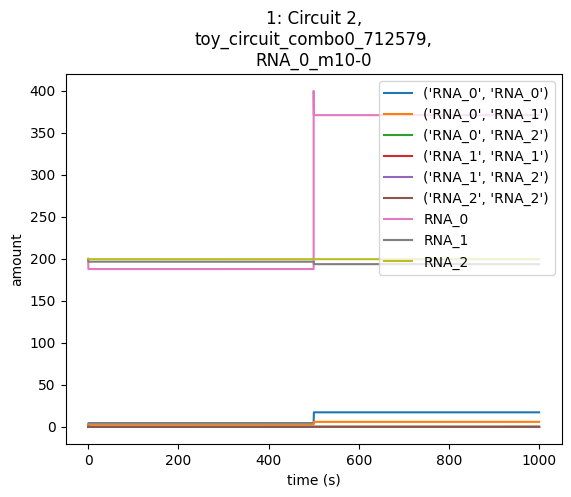

In [23]:

tdisplay = [0, len(tss) + len(tyy)]
plt.plot(np.concatenate([tss, tyy + tss[-1]])[tdisplay[0]:tdisplay[1]], np.concatenate([b_copynumbers[chosen_circuit_idx].T, b_new_copynumbers[chosen_circuit_idx].T])[tdisplay[0]:tdisplay[1]])
circ_type = 'Circuit 2' if circ in circuits2 else 'Circuit 1'
plt.title(f'{chosen_circuit_idx}: {circ_type},\n{circuits[chosen_circuit_idx].name},\n{circuits[chosen_circuit_idx].subname}')
plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1,1))
plt.ylabel('amount')

Directly calculate precision.

In [24]:
initial = b_new_copynumbers[chosen_circuit_idx][:, 0]
final = b_new_copynumbers[chosen_circuit_idx][:, -1]

signal_0 = initial[signal_species_idx]
signal_1 = final[signal_species_idx]

signal_diff = signal_1 - signal_0
output_diff = final - initial


denom = jnp.where(signal_0 != 0, signal_diff / signal_0, 1)
numer = jnp.where((initial != 0).astype(int),
                    output_diff / initial, 1)
precision = jnp.absolute(jnp.divide(
    numer, denom))

jnp.divide(1, precision)

Array([2.4848863e-02, 7.6223962e-02, 7.3971704e-02, 2.4399981e+00,
       4.7483506e+00, 1.1876401e+02, 1.0000000e+00, 4.8436613e+00,
       2.3754688e+02], dtype=float32)

### Investigate bug

There is a discrepancy between the analytics that were previously calculated and the analytics calculated here from the same circuit. The dynamics themselves must be different.

In [25]:
print(df_calculated[['precision_wrt_species-6', 'sensitivity_wrt_species-6']])
df_report[['precision_wrt_species-6', 'sensitivity_wrt_species-6']]


   precision_wrt_species-6  sensitivity_wrt_species-6
0                 0.024833                  40.243290
1                 0.076174                  13.123357
2                 0.073923                  13.520100
3                 2.438397                   0.409911
4                 4.745234                   0.210637
5               118.686066                   0.008422
6                 0.999344                   1.000000
7                 4.840483                   0.206492
8               237.391006                   0.004210


,precision_wrt_species-6,sensitivity_wrt_species-6
0,0.85584164,inf
1,0.85584164,inf
2,0.85584164,inf
3,28.96051,0.03452978
4,56.352325,0.017745497
5,1402.6597,0.00071293133
6,1.0,1.0
7,57.490128,0.017394291
8,2805.6387,0.0003564251


In [26]:
print(df_calculated['max_amount'])
df_report['max_amount']

0     17.374186
1      6.032713
2      0.124318
3      0.064899
4      0.065900
5      0.066916
6    400.000000
7    196.703781
8    199.736923
Name: max_amount, dtype: float32


0      17.37419
1     6.0317864
2     0.1243112
3    0.06489932
4    0.06589991
5    0.06691594
6     371.16833
7      196.7039
8     199.73662
Name: max_amount, dtype: object

In [27]:
print(df_report_ss['steady_states'])
b_copynumbers[chosen_circuit_idx][:, -2]

0     4.4540243
1     3.1001573
2    0.06296029
3    0.06489932
4    0.06589991
5    0.06691594
6     187.92947
7      196.7039
8     199.73662
Name: steady_states, dtype: object


array([4.4540362e+00, 3.1001482e+00, 6.2960349e-02, 6.4899236e-02,
       6.5899953e-02, 6.6916138e-02, 1.8792938e+02, 1.9670378e+02,
       1.9973692e+02], dtype=float32)

In [28]:
print(df_calculated['initial_steady_states'])
df_report['initial_steady_states']

0      4.454036
1      3.100148
2      0.062960
3      0.064899
4      0.065900
5      0.066916
6    400.000000
7    196.703781
8    199.736923
Name: initial_steady_states, dtype: float32


0           0.0
1           0.0
2           0.0
3    0.06489932
4    0.06589991
5    0.06691594
6         200.0
7      196.7039
8     199.73662
Name: initial_steady_states, dtype: object

What are we actually calculating in the function?f

In [29]:
# (b_copynumbers[:, :, -1] * ((signal.onehot == 0) * 1)) + \
#     (b_copynumbers[:, :, 0] *
#      signal_target) * signal.onehot


df_report_ss['steady_states'].astype(np.float64).to_numpy() * ((signal.onehot == 0) * 1) + \
(df_report_ss['initial_steady_states'].astype(np.float64).to_numpy() *
                             signal_target) * ((signal.onehot == 1) * 1)

array([4.4540243e+00, 3.1001573e+00, 6.2960290e-02, 6.4899320e-02,
       6.5899910e-02, 6.6915940e-02, 4.0000000e+02, 1.9670390e+02,
       1.9973662e+02])

In [30]:
(df_report_ss['initial_steady_states'].astype(np.float64).to_numpy() *
                             signal_target) * ((signal.onehot == 1) * 1)

array([  0.,   0.,   0.,   0.,   0.,   0., 400.,   0.,   0.])

In [31]:
b_og_states = df_report_ss['initial_steady_states'].astype(np.float64).to_numpy().flatten() * signal.onehot + df_report_ss['steady_states'].astype(np.float64).to_numpy().flatten() * ((signal.onehot == 0) * 1)
b_og_states


array([4.4540243e+00, 3.1001573e+00, 6.2960290e-02, 6.4899320e-02,
       6.5899910e-02, 6.6915940e-02, 2.0000000e+02, 1.9670390e+02,
       1.9973662e+02])

Prepend the og states to the copynumbers and get the precision

In [32]:
initial = df_report['max_amount'].astype(np.float64).to_numpy() # df_report['initial_steady_states'].astype(np.float64).to_numpy()  # b_og_states  # b_new_copynumbers[chid][:, 0]
final = b_new_copynumbers[chosen_circuit_idx][:, -1]

signal_0 = initial[signal_species_idx]
signal_1 = final[signal_species_idx]

signal_diff = signal_1 - signal_0
output_diff = final - initial


denom = jnp.where(signal_0 != 0, signal_diff / signal_0, 1)
numer = jnp.where((initial != 0).astype(int),
                    output_diff / initial, 1)
precision = jnp.absolute(jnp.divide(
    numer, denom))

jnp.divide(1, precision)

Array([7.3511777e+00, 1.9649881e+00, 1.4798046e+00, 6.3559033e-05,
       1.2369938e-04, 3.1089345e-03, 1.0000000e+00, 1.2617192e-04,
       6.2191803e-03], dtype=float32)

## Resimulate circuits with native functions

In [33]:


chosen_circuit_idx = 1

In [34]:

# stop
config, data_writer = script_preamble(config=config, data_writer=None)

In [35]:
config['simulation']['device'] = 'gpu'
config['experiment']['no_numerical'] = False
config['experiment']['no_visualisations'] = False
# config['simulation']['t1'] = 5


In [36]:
circuits1 = batch_load(circ_rows1, ref_c1, og_dir, config)
circuits2 = batch_load(circ_rows2, ref_c2, og_dir, config)
circuits = circuits1 + circuits2
circuit_modeller = CircuitModeller(result_writer=data_writer, config=config)

simulator.py:check_IntaRNA_path():112: Could not detect IntaRNA on system: CompletedProcess(args='which IntaRNA', returncode=1, stdout='', stderr='') WARNING


In [37]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [38]:

circuits = circuit_modeller.batch_circuits(
    circuits=circuits,
    write_to_subsystem=True,
    batch_size=config['simulation'].get('batch_size', 100),
    methods={
        # "compute_interactions": {},
        "init_circuits": {'batch': True},
        "simulate_signal_batch": {'ref_circuit': None,
                                'batch': config['simulation']['use_batch_mutations']}
        # "write_results": {'no_visualisations': False,
        #                   'no_numerical': False}
    })

circuit_manager.py:batch_circuits():581: 	From 40 circuits, a total of 40 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():588: 		Starting new round of viable circuits (0 - 40 / 40) WARNING
circuit_manager.py:batch_circuits():606: 		Making subcircuits 0 - 40 took 5.1e-05s WARNING
circuit_manager.py:batch_circuits():612: 	Batching 0 - 4000 circuits (out of 0 - 40 (total: 40)) (Circuits: 0 - 40 of 40) WARNING
circuit_manager.py:run_batch():643: 		Running 40 Subcircuits - toy_circuit_combo0_712579: init_circuits WARNING


In [ ]:
b_copynumbers_new_sim = np.asarray([c.result_collector.get_result('signal').data for c in circuits])

Write results

In [ ]:
circuits2 = circuit_modeller.batch_circuits(
    circuits=circuits,
    write_to_subsystem=True,
    batch_size=config['simulation'].get('batch_size', 100),
    methods={
        "write_results": {'no_visualisations': False,
                          'no_numerical': False}
    })

circuit_manager.py:batch_circuits():581: 	From 40 circuits, a total of 40 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():588: 		Starting new round of viable circuits (0 - 40 / 40) WARNING
circuit_manager.py:batch_circuits():606: 		Making subcircuits 0 - 40 took 4.1e-05s WARNING
circuit_manager.py:batch_circuits():612: 	Batching 0 - 4000 circuits (out of 0 - 40 (total: 40)) (Circuits: 0 - 40 of 40) WARNING
circuit_manager.py:run_batch():643: 		Running 40 Subcircuits - toy_circuit_combo0_712579: write_results WARNING


circuit_manager.py:run_batch():679: 		Method write_results took 12.736161s WARNING
circuit_manager.py:batch_circuits():626: Single batch: 0:00:12.737307 
Projected time: 12.737307s 
Total time: 0:00:12.737316 WARNING


In [ ]:
result_signal = circuits[chosen_circuit_idx].result_collector.get_result('signal')
result_signal.analytics['initial_steady_states']
result_signal.analytics['precision_wrt_species-6']
b_copynumbers_new_sim[chosen_circuit_idx, 6, 3]

371.16833

In [ ]:
result_ss = circuits[chosen_circuit_idx].result_collector.get_result('steady_states')
result_ss.data


array([[0.0000000e+00, 4.4540243e+00, 4.4540243e+00, ..., 4.4540243e+00,
        4.4540243e+00, 4.4540243e+00],
       [0.0000000e+00, 3.1001573e+00, 3.1001573e+00, ..., 3.1001573e+00,
        3.1001573e+00, 3.1001573e+00],
       [0.0000000e+00, 6.2960289e-02, 6.2960289e-02, ..., 6.2960289e-02,
        6.2960289e-02, 6.2960289e-02],
       ...,
       [2.0000000e+02, 1.8792947e+02, 1.8792947e+02, ..., 1.8792947e+02,
        1.8792947e+02, 1.8792947e+02],
       [2.0000000e+02, 1.9670390e+02, 1.9670390e+02, ..., 1.9670390e+02,
        1.9670390e+02, 1.9670390e+02],
       [2.0000000e+02, 1.9973662e+02, 1.9973662e+02, ..., 1.9973662e+02,
        1.9973662e+02, 1.9973662e+02]], dtype=float32)